In [7]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from tia.bbg import LocalTerminal
from pandas.tseries.offsets import *
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import sklearn.mixture as mix
import statsmodels.api as sm
import networkx as nx
from pprint import pprint 

import numpy as np
import scipy.stats as scs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns


In [8]:
# Getting BBG data and cleaning
StartDate = '1995-12-30'
EndDate = (dt.datetime.today()-BDay(1)).strftime("%m/%d/%Y")
GDPEndDate = (dt.datetime.today()-BDay(365)).strftime("%m/%d/%Y")

Dates = pd.DataFrame(pd.date_range(StartDate,EndDate,freq="D"),columns=['Date'])
Dates = Dates.set_index('Date',drop=True)
Dates.index.name = None

Month = pd.DataFrame(pd.date_range(StartDate,EndDate,freq="M"),columns=['Date'])
Month = Month.set_index('Date',drop=True)
Month.index.name = None

Quarter = pd.DataFrame(pd.date_range(StartDate,EndDate,freq="Q"),columns=['Date'])
Quarter = Quarter.set_index('Date',drop=True)
Quarter.index.name = None

In [9]:
# Take EPI data from excel

# Read EPI
GlbEPIEx = pd.ExcelFile('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\MacroRegEPI.xlsx').parse('MacroRegEPI')
GlbEPIEx.index = GlbEPIEx['Date']
GlbEPIEx = GlbEPIEx.drop(columns = ['Date'])
GlbEPIEx = GlbEPIEx.fillna(method='ffill')
GlbEPIEx = Dates.merge(GlbEPIEx,right_index=True,left_index=True,how='left')
GlbEPIEx = GlbEPIEx.fillna(method='ffill')
GlbEPIEx = Month.merge(GlbEPIEx,right_index=True,left_index=True,how='left')

In [11]:
GlbEPIEx.tail()

EpiM_Headline_AU  EpiM_Business_AU  EpiM_Consumer_AU  \
2019-08-31         -1.201616         -0.810514         -1.547828   
2019-09-30         -1.122207         -0.709136         -0.904735   
2019-10-31         -1.152160         -0.680101         -0.742778   
2019-11-30         -1.093602         -0.386141         -0.380259   
2019-12-31         -0.955334         -0.722078         -0.376885   

            EpiM_Employment_AU  EpiM_Growth_AU  EpiM_Inflation_AU  \
2019-08-31           -0.238016       -1.173196          -0.109109   
2019-09-30           -0.289336       -1.264090          -0.267672   
2019-10-31           -0.422667       -1.250853          -0.378492   
2019-11-30           -0.878802       -1.183764          -0.398445   
2019-12-31           -0.134679       -1.090942          -0.406488   

            EpiM_Headline_NZ  EpiM_Business_NZ  EpiM_Consumer_NZ  \
2019-08-31          0.130303         -1.020304         -0.354152   
2019-09-30         -0.030897         -1.206799         -0.276482   
2019-10-31         -0.095115         -1.216050         -0.208466   
2019-11-30          0.181349         -0.630998          0.170338   
2019-12-31          0.663546         -0.369224          0.546356   

            EpiM_Employment_NZ  ...  EpiM_Consumer_UK  EpiM_Employment_UK  \
2019-08-31            1.438950  ...          0.072789            0.177752   
2019-09-30            1.428814  ...          0.009009            0.166787   
2019-10-31            1.398130  ...          0.066458            0.229262   
2019-11-30            1.078143  ...         -0.075605            0.062089   
2019-12-31            1.072784  ...         -0.109736            0.071851   

            EpiM_Growth_UK  EpiM_Inflation_UK  EpiM_Headline_Global  \
2019-08-31       -0.536816          -0.801183             -0.469911   
2019-09-30       -0.535227          -0.380680             -0.325728   
2019-10-31       -0.531307          -0.945866             -0.447875   
2019-11-30       -0.077558          -1.271533             -0.525725   
2019-12-31        0.009556          -0.794296             -0.520160   

            EpiM_Business_Global  EpiM_Consumer_Global  \
2019-08-31             -0.711712             -0.442848   
2019-09-30             -0.614337             -0.283837   
2019-10-31             -0.703352             -0.306907   
2019-11-30             -0.716446             -0.368442   
2019-12-31             -1.026876             -0.476515   

            EpiM_Employment_Global  EpiM_Growth_Global  EpiM_Inflation_Global  
2019-08-31                0.199673           -0.326406              -0.337889  
2019-09-30                0.404698           -0.305914              -0.347894  
2019-10-31                0.302243           -0.377753              -0.475776  
2019-11-30                0.171067           -0.458164              -0.393423  
2019-12-31                0.304541           -0.554854               0.096949  

[5 rows x 42 columns]

In [12]:
# Take Bloomberg data from excel

# Read Bloomberg Data
Ecodata = pd.ExcelFile('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\MacroRegBBGUpdate.xlsx').parse('Month')
Ecodata = Ecodata.iloc[2:]
Ecodata.index = Ecodata['NAME']
Ecodata = Ecodata.drop(columns = ['NAME'])
Ecodata = Ecodata.fillna(method='ffill')
Ecodata = Dates.merge(Ecodata,right_index=True,left_index=True,how='left')
Ecodata = Ecodata.fillna(method='ffill')
Ecodata = Month.merge(Ecodata,right_index=True,left_index=True,how='left')


# Read in half-yearly bak NIMs
BankData1 = pd.ExcelFile('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\MacroRegBBGUpdate.xlsx').parse('Quarter')
BankData1 = BankData1.iloc[1:]
BankData1.index = BankData1['Unnamed: 0']
BankData1 = BankData1.drop(columns = ['Unnamed: 0'])
BankData1 = BankData1.fillna(method='ffill')
BankData1 = Dates.merge(BankData1,right_index=True,left_index=True,how='left')
BankData1 = BankData1.fillna(method='ffill')
BankData1 = Month.merge(BankData1,right_index=True,left_index=True,how='left')
Ecodata = Ecodata.merge(BankData1,right_index=True,left_index=True,how='left')

#Read in quarterly Bank NIMs
BankData2 = pd.ExcelFile('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\MacroRegBBGUpdate.xlsx').parse('BiAnn')
BankData2 = BankData2.iloc[1:]
BankData2.index = BankData2['Unnamed: 0']
BankData2 = BankData2.drop(columns = ['Unnamed: 0'])
BankData2 = BankData2.fillna(method='ffill')
BankData2 = Dates.merge(BankData2,right_index=True,left_index=True,how='left')
BankData2 = BankData2.fillna(method='ffill')
BankData2 = Month.merge(BankData2,right_index=True,left_index=True,how='left')
Ecodata = Ecodata.merge(BankData2,right_index=True,left_index=True,how='left')

In [13]:
# Put the codes in 

NamesIdx = ['EPI ex inflation M','EPI ex inflation L','EPI Synchronised Sectors or Regions M','EPI Synchronised Sectors or Regions L',
'Earnings Growth M','Earnings Growth L','Investment/Capex M','Investment/Capex L','Credit Growth M',
'Credit Growth L','Inventory Cycle M',
'Inventory Cycle L','Global Trade M','Global Trade L','Fiscal Impulse M','Fiscal Impulse L',
'EPI Inflation M','EPI Inflation L','Wage Inflation M','Wage Inflation L','Core (Persistence/Breadth) M',
'Core (Persistence/Breadth) L','OECD Output Gap M','OECD Output Gap L','Employment EPI M',
'Employment EPI L','Unemployment level vs NAIRU M','Unemployment level vs NAIRU L',
'Capacity Utilisation M','Capacity Utilisation L','Property (1y momentum) M','Property (level) L',
'Equities M','Equities L','Household Leverage M','Household Leverage L','Corporate Leverage M',
'Corporate Leverage L','Government Leverage M','Government Leverage L',
'Public Sector Liquidity ==> Reserves, Central Bank BS M','Public Sector Liquidity ==> Reserves, Central Bank BS L',
'Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) M',
'Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) L',
'Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc M',
'Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc L',
'Real Policy Rate vs real neutral rate M','Real Policy Rate vs real neutral rate L','Real Long End Yields M',
'Real Long End Yield L','Real Ccy vs ToT M','Real Ccy vs ToT L','Financial Sector Health M',
'Financial Sector Health L','Credit Spreads M','Credit Spreads L']

In [24]:
CodesIdx = ['MXWD Index BEPS','MXWD Index PE','IP YOY Index','GPDITOC% Index','JNIPYOY Index','JNVNYOYS Index','E600CEAY Index',
'FCFNEMUY Index','BZIPYOY% Index','RUIPRNYY Index','INPIINDY Index','CNFAYOY Index','ALCBLOAN Index',
'JPALDBLB Index','ECMSLONS Index','BZLNTOTA Index','RULRLOAN Index','IIIPLOBA Index','CNMS1YOY Index',
'MGT2TB Index','JNVSIVTS Index','GEIFOMIA Index','SKLIINVC Index','CPMIIFGS Index','USTBEXPY Index',
'USTBIMPY Index','JNVOEXPY Index','JNVOIMPY Index','XTSXEZ Index','XTSIEZ Index','BZTBEXPM Index',
'BZTBIMPM Index','RUTREM Index','RUTRI Index','INMTEXUY Index','INMTIMUY Index','CNFREXPY Index',
'CNFRIMPY Index','FDDSGDP Index','JGDPPBDY Index','EXPNDESU Index','BZPBNO% Index','EHBBRU Index',
'EHBBIN Index','EHBBCNY Index','AHE TOTL Index','JNLSUCTL Index','LNTNEMUY Index','BZCNWAGE Index',
'RUMENOYY Index','INBGRIWG Index','OEEOCNBR Index','CPI XYOY Index','JCPTEFEY Index','CPEXEMUY Index',
'BBNCSMOT Index','RUCPBIYY Index','INBGCEY Index','CNCPCRY Index','USURTOT Index','CBOPNRUE Index',
'JNUE Index','OEEOJPUQ Index','UMRTEMU Index','BCMPNREA Index','BRLFUNRT Index','RUUER Index',
'INUNCIA Index','CNUERATE Index','CPTICHNG Index','JNCAP Index','EUUCEMU Index','SPCS20Y% Index',
'JHPITNAY Index','HOPIEUI Index','BZEAIVGR Index','RUPHERF Index','CHHEAVG Index',
'SLDETIGT Index','JBKOCM Index','EBLS61NC Index','CPNFUSHG Index','CPNFJPHG Index','CPNFXMHG Index',
'CPNFCNHG Index','CPNFUSNG Index','CPNFJPNG Index','CPNFXMNG Index','CPNFCNNG Index','CPNFUSOG Index',
'CPNFJPOG Index','CPNFXMOG Index','CPNFCNOG Index','FARBCRED Index','EBBSTOTA Index','EURUSD Curncy',
'BJACTOTL Index','JPYUSD Curncy','CNBMTTAS Index','CNYUSD Curncy','ARDIMONY Index','JNMBMOB Index',
'EULPBM Index','BZMS1 Index','RMSNM1 Index','INMSM1Y Index','CNMSM1 Index','USCABAL Index',
'ECOCEAS Index','ECOCJPN Index','ECOCCNN Index','FDTR Index','G0169 5Y5Y BLC2 Curncy',
'BOJDPBAL Index','FWISJY55 Index','EUORDEPO Index','FWISEU55 Index','BZSTSETA Index',
'BZPIIPCY Index','RREFKEYR Index','RUCPIYOY Index','INRPYLD Index','INFUTOTY Index',

'GCNY1YR Index','CNCPIYOY Index','USNRUS Index','USNREUAR Index','USGG10YR Index',
'GJGB10 Index','GECU10YR Index',
'GEBR10Y Index','MICXRU10 Index','GIND10YR Index','GCNY10YR Index','111.028 Index','CTOTUSD Index',
'JPM US Equity','BAC US Equity','C US Equity','WFC US Equity','USB US Equity','CBK GR Equity',
'DBK GR Equity','UCG IM Equity','ISP IM Equity','SAN SM Equity',
'CABK SM Equity','LGCPOAS Index']



In [15]:
CodesNamesIdx = ['MSCI ACWI','US Industrial Production YOY S','US Gross Private Domestic Inve','Japan Indices of Industrial Pr',
'Japan Capital Investment YoY','EU Ind Prod Manufacturing Euro','Euro Area  Gross Fixed Capital',
'Brazil Industrial Production N','Russia Industrial Production 2','India Industrial Production',
'China Fixed Assets Investment','US Commercial Bank Assets Loan','JP Domestically Licensed Banks',
'ECB Money Aggregates Credit to','Brazil Financial System Loans','Russia Loans to Corps and Indi',
'India Assets Loans Banks','China Monthly Money Supply M1','MFG+TRD INV/SALES RATIO TOTAL',
'Japan Inventories to Sales Rat','IFO Germany Manufacturing Inve','South Korea Leading - Inventor',
'China Stocks of Finished Goods','US Trade Balance of Exports YO','US Trade Balance of Imports Yo',
'Japan Merchandise Trade Export','Japan Merchandise Trade Import','Eurozone Export to Non Eurozon',
'Eurozone Import from Non Euroz','Brazil Trade Balance FOB Expor','Brazil Trade Balance FOB Impor',
'Russia Trade Exports','Russia Trade Imports Year to D','India Merchandise Exports Incl',
'India Merchandise Imports YoY','China Export Trade USD YoY','China Import Trade USD YoY',
'US Treasury Federal Budget Def','Japan GDP Chained Real Public','ECB Deficit / Surplus',
'Brazil Public Nominal Budget R','Russia Budget Balance (% GDP)','India Budget Balance (% GDP)',
'China Budget Balance (% GDP)','US Average Hourly Earnings All','Japan Labour Statistics Avg Mo',
'Eurostat Labor Costs Nominal V','CNI Brazil Manufacture Industr','Russia Nominal Monthly Wages Y',
'Rural India Wage Growth','OECD Eco Outlook China Competi','US CPI Urban Consumers Less Fo',
'Japan CPI Tokyo Ex Food & Ener','Eurostat Eurozone Core MUICP Y','Brazil Broad National CPI Core',
'Russia Core Inflation YoY','India Core-CPI Ex Food & Fuel','China Core CPI (excluding Food',
'U-3 US Unemployment Rate Total','Congressional Budget Office Sh','Japan Unemployment Rate SA',
'OECD Eco Outlook Japan NAIRU -','Eurostat Unemployment Eurozone','Bloomberg Economics Euro Area',
'Brazil PNAD Unemployment Rate','Russia Unemployment Rate','India CIA Unemployment Rate Es',
'China Qtrly Registered Unemplo','US Capacity Utilization % of T','Japan Capacity Utilization Ope',
'European Commission Capacity U','S&P CoreLogic Case-Shiller 20-','Japan House Price Index All Ja',
'Eurostat House Price Index Eur','Brazil Residential Real Estate','Russia Housing Prices Existing',
'China 70 Cities Newly Built Co','MSCI ACWI','Net % of Domestic Respondents','Japan Banks Senior Officer Sur',
'ECB Survey Expected Change in','BIS United States Credit to Ho','BIS Japan Credit to Households',
'BIS Euro Area Credit to Househ','BIS China Credit to Households','BIS United States Credit to No',
'BIS Japan Credit to Non Financ','BIS Euro Area Credit to Non Fi','BIS China Credit to Non Financ',
'BIS United States Credit to Ge','BIS Japan Credit to General Go','BIS Euro Area Credit to Genera',
'BIS China Credit to General Go','US Factors Supplying Reserve F','ECB Balance Sheet All Assets',
'EUR-USD X-RATE','Bank of Japan assets:Total','JPY-USD X-RATE','China Central Bank Balance She',
'CNY-USD X-RATE','Monetary Base Total NSA','BOJ Monetary Base Avg Outstand','ECB Base Money',
'Brazil Money Supply M1 Brazil','Russia Money Supply Narrow Def','India Money Supply M1 YoY',
'China Monthly Money Supply M1','US Nominal Account Balance In','Eurozone Current Account Balan',
'Japan Current Account Balance','China Current Account Balance','Federal Funds Target Rate - Up',
'USD INFL FORWARD RATE 5Y5Y','Bank Of Japan Policy-Rate Bala','JPY Inflation Swap Forward 5Y5',
'ECB Deposit Facility Announcem','EUR Inflation Swap Forward 5Y5','Brazil Selic Target Rate',
'Brazil CPI IPCA YoY','Bank of Russia Key Rate','Russia CPI YoY','Reserve Bank of India Repurcha',
'#N/A Invalid Security','China Govt Bond Generic Bid Yi','China CPI YoY',
'Laubach Williams Natural Rate','Laubach Williams Natural Rate','US Generic Govt 10 Year Yield',
'USD INFL FORWARD RATE 5Y5Y','Japan Generic Govt 10Y Yield','JPY Inflation Swap Forward 5Y5',
'Euro Generic Govt Bond 10 Year','EUR Inflation Swap Forward 5Y5','Brazil Government Generic Bond',
'MICEX Russia Zero Cpn 10 Year','India Govt Bond Generic Bid Yi','China Govt Bond Generic Bid Yi',
'IMF US Real Effective Exchange','Citi Terms of Trade Index - Un','JPMORGAN CHASE & CO',
'BANK OF AMERICA CORP','CITIGROUP INC','WELLS FARGO & CO','US BANCORP','COMMERZBANK AG',
'DEUTSCHE BANK AG-REGISTERED','CREDIT AGRICOLE SA','SOCIETE GENERALE SA','UNICREDIT SPA',
'INTESA SANPAOLO','BANCO SANTANDER SA','CAIXABANK SA','Bloomberg Barclays Global Agg']

GDPNames = ['US','Japan','Eurozone','Brazil','Russia','India','China']
GDPIdx = ['IGN$USA Index','IGN$JPN Index','IGN$EURO Index','IGN$BRA Index','IGN$RUS Index','IGN$IND Index',
'IGN$CHN Index']

In [16]:
#### Global Output Gap Code

CountryNames = ['AUSTRALIA','NEW ZEALAND','JAPAN','US','CANADA','IRELAND','UK','GERMANY','FRANCE','SWITZERLAND','SPAIN',
'NETHERLANDS','NORWAY','SWEDEN','DENMARK','ITALY','BELGIUM','GREECE','TURKEY','POLAND','CZECHIA','HUNGARY','CHILE',
'MEXICO',]

OutputGapNames = ['OEEOAUUG Index','OEEONZUG Index','OEEOJPUG Index','OEEOUSUG Index','OEEOCAUG Index','OEEOIEUG Index',
'OEEOGBUG Index','OEEODEUG Index','OEEOFRUG Index','OEEOCHUG Index','OEEOESUG Index','OEEONLUG Index','OEEONOUG Index',
'OEEOSEUG Index','OEEODKUG Index','OEEOITUG Index','OEEOBEUG Index','OEEOGRUG Index','OEEOTRUG Index','OEEOPLUG Index',
'OEEOCZUG Index','OEEOHUUG Index','OEEOCLUG Index','OEEOMXUG Index',]

IMFDOTSExports = ['193D0001 Index','196D0001 Index','158D0001 Index','111D0001 Index','156D0001 Index',
'178D0001 Index','112D0001 Index','134D0001 Index','132D0001 Index','146D0001 Index','184D0001 Index','138D0001 Index',
'142D0001 Index','144D0001 Index','128D0001 Index','136D0001 Index','124D0001 Index','174D0001 Index','186D0001 Index',
'964D0001 Index','935D0001 Index','944D0001 Index','228D0001 Index','273D0001 Index',]

IMFDOTImports =['193D1001 Index','196D1001 Index','158D1001 Index','111D1001 Index','156D1001 Index',
'178D1001 Index','112D1001 Index','134D1001 Index','132D1001 Index','146D1001 Index','184D1001 Index','138D1001 Index',
'142D1001 Index','144D1001 Index','128D1001 Index','136D1001 Index','124D1001 Index','174D1001 Index','186D1001 Index',
'964D1001 Index','935D1001 Index','944D1001 Index','228D1001 Index','273D1001 Index',]

In [20]:
# Output Gap Generation

# Copies of the data 

OutputGap = pd.DataFrame(0,index=Month.index, columns=['Blank'])
for i in OutputGapNames:
    OutputGap = OutputGap.merge(pd.DataFrame(Ecodata[[i]]),right_index=True,left_index=True,how='left')
OutputGap = OutputGap.drop(columns=['Blank'])
OutputGap.columns = CountryNames

DotsExports = pd.DataFrame(0,index=Month.index, columns=['Blank'])

for i in IMFDOTSExports:
    DotsExports = DotsExports.merge(Ecodata[[i]],right_index=True,left_index=True,how='left')
DotsExports = DotsExports.drop(columns=['Blank'])
DotsExports.columns = CountryNames

DotsImports = pd.DataFrame(0,index=Month.index, columns=['Blank'])

for i in IMFDOTImports:
    DotsImports = DotsImports.merge(Ecodata[[i]],right_index=True,left_index=True,how='left')
DotsImports = DotsImports.drop(columns=['Blank'])
DotsImports.columns = CountryNames

#Create Trade Weights

DotsTrade = DotsExports + DotsImports
DotsTradeSUM = DotsTrade.sum(axis=1)

DotsTradeSum = pd.DataFrame(Month.index,columns=['index'])
DotsTradeSum = DotsTradeSum.set_index(['index'],drop=True)
DotsTradeSum.index.name = None

for i in range(len(OutputGap.columns)):
    TotalSumCopy = pd.DataFrame(DotsTradeSUM.copy())
    DotsTradeSum = DotsTradeSum.merge(TotalSumCopy,right_index=True,left_index=True,how='left')
    
DotsTradeSum.columns = CountryNames    
DotsWeight = (DotsTrade/DotsTradeSum)

WeightedOuputG = OutputGap*DotsWeight
GlobalOutputGap = pd.DataFrame(WeightedOuputG.sum(axis=1))

# Convert to Quarterly
#GlobalOutputGap = Quarter.merge(GlobalOutputGap,right_index=True,left_index=True,how='left')

In [25]:
# Create GDP Weights
GDPNomAnn = pd.DataFrame(0,index=Month.index, columns=['Blank'])
for i in GDPIdx:
    GDPNomAnn = GDPNomAnn.merge(pd.DataFrame(Ecodata[[i]]),right_index=True,left_index=True,how='left')
GDPNomAnn = GDPNomAnn.drop(columns=['Blank'])
GDPNomAnn.columns = GDPNames
GDPNomAnn[GDPNames] = GDPNomAnn[GDPNames].div(GDPNomAnn[GDPNames].sum(axis=1), axis=0)

#GDPNomAnn.tail()

In [26]:
#Copies and Adjustments

#Main Code df
RegCode = pd.DataFrame(0,index=Month.index, columns=NamesIdx)

PXLast = pd.DataFrame(0,index=Month.index, columns=['Blank'])
for i in CodesIdx:
    PXLast = PXLast.merge(pd.DataFrame(Ecodata[[i]]),right_index=True,left_index=True,how='left')
PXLast = PXLast.drop(columns=['Blank'])

#Add in EPI
PXLast['EpiM_Headline_Global'] = GlbEPIEx['EpiM_Headline_Global'].copy()
PXLast['EpiM_Business_Global'] = GlbEPIEx['EpiM_Business_Global'].copy()
PXLast['EpiM_Consumer_Global'] = GlbEPIEx['EpiM_Consumer_Global'].copy()
PXLast['EpiM_Employment_Global'] = GlbEPIEx['EpiM_Employment_Global'].copy()
PXLast['EpiM_Growth_Global'] = GlbEPIEx['EpiM_Growth_Global'].copy()
PXLast['EpiM_Inflation_Global'] = GlbEPIEx['EpiM_Inflation_Global'].copy()

# Create GDP Weights
#GDPNomAnn[GDPNames] = GDPNomAnn[GDPNames].div(GDPNomAnn[GDPNames].sum(axis=1), axis=0)


In [27]:
PXLast.tail()

MXWD Index BEPS  MXWD Index PE  IP YOY Index  GPDITOC% Index  \
2019-08-31            32.37        15.7818          0.38            -6.3   
2019-09-30            32.15        16.1928         -0.20            -1.0   
2019-10-31            32.18        16.6044         -1.30            -1.0   
2019-11-30            31.85        17.1673         -0.75            -1.0   
2019-12-31            31.91        17.7140         -0.75            -1.0   

            JNIPYOY Index  JNVNYOYS Index  E600CEAY Index  FCFNEMUY Index  \
2019-08-31           -4.7             1.9            -2.8             8.8   
2019-09-30            1.3             7.1            -1.8             8.1   
2019-10-31           -7.7             7.1            -2.3             8.1   
2019-11-30           -8.1             7.1            -2.3             8.1   
2019-12-31           -8.1             7.1            -2.3             8.1   

            BZIPYOY% Index  RUIPRNYY Index  ...  ISP IM Equity  SAN SM Equity  \
2019-08-31            -2.1             2.9  ...         0.9097         2.9710   
2019-09-30             1.1             3.0  ...         0.8714         2.8462   
2019-10-31             1.1             2.6  ...         0.8714         2.8462   
2019-11-30            -1.7             0.3  ...         0.8714         2.8462   
2019-12-31            -1.7             0.3  ...         0.8714         2.8462   

            CABK SM Equity  LGCPOAS Index  EpiM_Headline_Global  \
2019-08-31          1.6955           1.21             -0.469911   
2019-09-30          1.6955           1.18             -0.325728   
2019-10-31          1.6955           1.12             -0.447875   
2019-11-30          1.6955           1.08             -0.525725   
2019-12-31          1.6955           0.98             -0.520160   

            EpiM_Business_Global  EpiM_Consumer_Global  \
2019-08-31             -0.711712             -0.442848   
2019-09-30             -0.614337             -0.283837   
2019-10-31             -0.703352             -0.306907   
2019-11-30             -0.716446             -0.368442   
2019-12-31             -1.026876             -0.476515   

            EpiM_Employment_Global  EpiM_Growth_Global  EpiM_Inflation_Global  
2019-08-31                0.199673           -0.326406              -0.337889  
2019-09-30                0.404698           -0.305914              -0.347894  
2019-10-31                0.302243           -0.377753              -0.475776  
2019-11-30                0.171067           -0.458164              -0.393423  
2019-12-31                0.304541           -0.554854               0.096949  

[5 rows x 154 columns]

In [28]:
# Start adjusting data series

#YOY%
PXLast['ALCBLOAN Index'] = (PXLast['ALCBLOAN Index']/PXLast['ALCBLOAN Index'].shift(12) -1)
PXLast['JPALDBLB Index'] = (PXLast['JPALDBLB Index']/PXLast['JPALDBLB Index'].shift(12) -1)
PXLast['ECMSLONS Index'] = (PXLast['ECMSLONS Index']/PXLast['ECMSLONS Index'].shift(12) -1)
PXLast['BZLNTOTA Index'] = (PXLast['BZLNTOTA Index']/PXLast['BZLNTOTA Index'].shift(12) -1)
PXLast['RULRLOAN Index'] = (PXLast['RULRLOAN Index']/PXLast['RULRLOAN Index'].shift(12) -1)
PXLast['IIIPLOBA Index'] = (PXLast['IIIPLOBA Index']/PXLast['IIIPLOBA Index'].shift(12) -1)
PXLast['CNMS1YOY Index'] = (PXLast['CNMS1YOY Index']/PXLast['CNMS1YOY Index'].shift(12) -1)
PXLast['USTBEXPY Index'] = (PXLast['USTBEXPY Index']/PXLast['USTBEXPY Index'].shift(12) -1)
PXLast['USTBIMPY Index'] = (PXLast['USTBIMPY Index']/PXLast['USTBIMPY Index'].shift(12) -1)
PXLast['JNVOEXPY Index'] = (PXLast['JNVOEXPY Index']/PXLast['JNVOEXPY Index'].shift(12) -1)
PXLast['JNVOIMPY Index'] = (PXLast['JNVOIMPY Index']/PXLast['JNVOIMPY Index'].shift(12) -1)
PXLast['XTSXEZ Index'] = (PXLast['XTSXEZ Index']/PXLast['XTSXEZ Index'].shift(12) -1)
PXLast['XTSIEZ Index'] = (PXLast['XTSIEZ Index']/PXLast['XTSIEZ Index'].shift(12) -1)
PXLast['BZTBEXPM Index'] = (PXLast['BZTBEXPM Index']/PXLast['BZTBEXPM Index'].shift(12) -1)
PXLast['BZTBIMPM Index'] = (PXLast['BZTBIMPM Index']/PXLast['BZTBIMPM Index'].shift(12) -1)
PXLast['RUTREM Index'] = (PXLast['RUTREM Index']/PXLast['RUTREM Index'].shift(12) -1)
PXLast['RUTRI Index'] = (PXLast['RUTRI Index']/PXLast['RUTRI Index'].shift(12) -1)
PXLast['AHE TOTL Index'] = (PXLast['AHE TOTL Index']/PXLast['AHE TOTL Index'].shift(12) -1)
PXLast['JNLSUCTL Index'] = (PXLast['JNLSUCTL Index']/PXLast['JNLSUCTL Index'].shift(12) -1)
PXLast['LNTNEMUY Index'] = (PXLast['LNTNEMUY Index']/PXLast['LNTNEMUY Index'].shift(12) -1)
PXLast['BZCNWAGE Index'] = (PXLast['BZCNWAGE Index']/PXLast['BZCNWAGE Index'].shift(12) -1)
PXLast['OEEOCNBR Index'] = (PXLast['OEEOCNBR Index']/PXLast['OEEOCNBR Index'].shift(12) -1)
PXLast['HOPIEUI Index'] = (PXLast['HOPIEUI Index']/PXLast['HOPIEUI Index'].shift(12) -1)
PXLast['BZEAIVGR Index'] = (PXLast['BZEAIVGR Index']/PXLast['BZEAIVGR Index'].shift(12) -1)
PXLast['RUPHERF Index'] = (PXLast['RUPHERF Index']/PXLast['RUPHERF Index'].shift(12) -1)
PXLast['ARDIMONY Index'] = (PXLast['ARDIMONY Index']/PXLast['ARDIMONY Index'].shift(12) -1)
PXLast['JNMBMOB Index'] = (PXLast['JNMBMOB Index']/PXLast['JNMBMOB Index'].shift(12) -1)
PXLast['EULPBM Index'] = (PXLast['EULPBM Index']/PXLast['EULPBM Index'].shift(12) -1)
PXLast['BZMS1 Index'] = (PXLast['BZMS1 Index']/PXLast['BZMS1 Index'].shift(12) -1)
PXLast['RMSNM1 Index'] = (PXLast['RMSNM1 Index']/PXLast['RMSNM1 Index'].shift(12) -1)
PXLast['CNMSM1 Index'] = (PXLast['CNMSM1 Index']/PXLast['CNMSM1 Index'].shift(12) -1)


# Unemployment vs BBG Economic's NAIRU estimate
PXLast['USURTOT Index'] = (PXLast['USURTOT Index'] - PXLast['CBOPNRUE Index'])
PXLast['JNUE Index'] = (PXLast['JNUE Index'] - PXLast['OEEOJPUQ Index'])
PXLast['UMRTEMU Index'] = (PXLast['UMRTEMU Index'] - PXLast['BCMPNREA Index'])


# Inverse for fiscal, unemployment and debt
PXLast['MGT2TB Index'] = -1*PXLast['MGT2TB Index']
PXLast['SKLIINVC Index'] = -1*PXLast['SKLIINVC Index']
PXLast['FDDSGDP Index'] = -1*PXLast['FDDSGDP Index']
PXLast['JGDPPBDY Index'] = -1*PXLast['JGDPPBDY Index']
PXLast['EXPNDESU Index'] = -1*PXLast['EXPNDESU Index']
PXLast['BZPBNO% Index'] = -1*PXLast['BZPBNO% Index']
PXLast['EHBBRU Index'] = -1*PXLast['EHBBRU Index']
PXLast['EHBBIN Index'] = -1*PXLast['EHBBIN Index']
PXLast['EHBBCNY Index'] = -1*PXLast['EHBBCNY Index']
PXLast['USURTOT Index'] = -1*PXLast['USURTOT Index']
PXLast['CBOPNRUE Index'] = -1*PXLast['CBOPNRUE Index']
PXLast['JNUE Index'] = -1*PXLast['JNUE Index']
PXLast['OEEOJPUQ Index'] = -1*PXLast['OEEOJPUQ Index']
PXLast['UMRTEMU Index'] = -1*PXLast['UMRTEMU Index']
PXLast['BCMPNREA Index'] = -1*PXLast['BCMPNREA Index']
PXLast['BRLFUNRT Index'] = -1*PXLast['BRLFUNRT Index']
PXLast['RUUER Index'] = -1*PXLast['RUUER Index']
PXLast['INUNCIA Index'] = -1*PXLast['INUNCIA Index']
PXLast['CNUERATE Index'] = -1*PXLast['CNUERATE Index']
PXLast['SLDETIGT Index'] = -1*PXLast['SLDETIGT Index']
PXLast['JBKOCM Index'] = -1*PXLast['JBKOCM Index']
PXLast['EBLS61NC Index'] = -1*PXLast['EBLS61NC Index']
PXLast['CPNFUSHG Index'] = -1*PXLast['CPNFUSHG Index']
PXLast['CPNFJPHG Index'] = -1*PXLast['CPNFJPHG Index']
PXLast['CPNFXMHG Index'] = -1*PXLast['CPNFXMHG Index']
PXLast['CPNFCNHG Index'] = -1*PXLast['CPNFCNHG Index']
PXLast['CPNFUSNG Index'] = -1*PXLast['CPNFUSNG Index']
PXLast['CPNFJPNG Index'] = -1*PXLast['CPNFJPNG Index']
PXLast['CPNFXMNG Index'] = -1*PXLast['CPNFXMNG Index']
PXLast['CPNFCNNG Index'] = -1*PXLast['CPNFCNNG Index']
PXLast['CPNFUSOG Index'] = -1*PXLast['CPNFUSOG Index']
PXLast['CPNFJPOG Index'] = -1*PXLast['CPNFJPOG Index']
PXLast['CPNFXMOG Index'] = -1*PXLast['CPNFXMOG Index']
PXLast['CPNFCNOG Index'] = -1*PXLast['CPNFCNOG Index']




# Central Bank Balance sheet, convert all CB B/S to USD and Sum
PXLast['FARBCRED Index'] = ((PXLast['FARBCRED Index']/1000)+(PXLast['EBBSTOTA Index']*PXLast['EURUSD Curncy'])
                            +(PXLast['BJACTOTL Index']*PXLast['JPYUSD Curncy'])
                            +(PXLast['CNBMTTAS Index']*PXLast['CNYUSD Curncy']))                            
                            
# Current Account Balance G4 Sums
PXLast['USCABAL Index'] = PXLast['USCABAL Index']+PXLast['ECOCEAS Index']+PXLast['ECOCJPN Index']+PXLast['ECOCCNN Index']

# Real Rate Calcs policy and long end, and vs neutral rate for policy
PXLast['USGG10YR Index'] = -(PXLast['G0169 5Y5Y BLC2 Curncy'] - PXLast['USGG10YR Index']) #Real long end
PXLast['FDTR Index'] = -1*((PXLast['FDTR Index'] - PXLast['G0169 5Y5Y BLC2 Curncy'])
                        -(0.5*PXLast['USNRUS Index']+0.5*PXLast['USNREUAR Index'])) #Real policy rate
PXLast['EUORDEPO Index'] = ((PXLast['USNREUAR Index']*0.7 + PXLast['USNRUS Index']*0.3) 
                            -(PXLast['EUORDEPO Index'] - PXLast['FWISEU55 Index']))
PXLast['GECU10YR Index'] = (PXLast['FWISEU55 Index']-PXLast['GECU10YR Index'])
PXLast['BOJDPBAL Index'] = ((PXLast['USNREUAR Index']*0.7 + PXLast['USNRUS Index']*0.3) 
                            -(PXLast['BOJDPBAL Index'] - PXLast['FWISJY55 Index']))
PXLast['GJGB10 Index'] = (PXLast['FWISJY55 Index']-PXLast['GJGB10 Index'])
                          

# Real currency v Terms of trade
PXLast['111.028 Index'] = PXLast['CTOTUSD Index']/PXLast['111.028 Index']

# Add Output Gap
PXLast['Output Gap'] = GlobalOutputGap


In [29]:
# Z-scoring at different time frames

# 0.5Y
PXLast05Yzs = (PXLast - PXLast.rolling(6).mean())/PXLast.rolling(6).std()

#1y
PXLast1Yzs = (PXLast - PXLast.rolling(12).mean())/PXLast.rolling(12).std()

#3Y
PXLast3Yzs = (PXLast - PXLast.rolling(3*12).mean())/PXLast.rolling(3*12).std()

#5y
PXLast5Yzs = pd.DataFrame((PXLast - PXLast.rolling(5*12).mean())/PXLast.rolling(5*12).std())

#7Y
PXLast7Yzs = (PXLast - PXLast.rolling(7*12).mean())/PXLast.rolling(7*12).std()

#10Y
PXLast10Yzs = (PXLast - PXLast.rolling(10*12).mean())/PXLast.rolling(10*12).std()


In [30]:
GDPNomAnn.tail()

US     Japan  Eurozone    Brazil    Russia     India  \
2019-08-31  0.349986  0.084550  0.231945  0.031764  0.028184  0.046235   
2019-09-30  0.349986  0.084550  0.231945  0.031764  0.028184  0.046235   
2019-10-31  0.349986  0.084550  0.231945  0.031764  0.028184  0.046235   
2019-11-30  0.349986  0.084550  0.231945  0.031764  0.028184  0.046235   
2019-12-31  0.354555  0.085242  0.220180  0.030545  0.027087  0.048547   

               China  
2019-08-31  0.227337  
2019-09-30  0.227337  
2019-10-31  0.227337  
2019-11-30  0.227337  
2019-12-31  0.233843

In [31]:
# Add in Adjusted Series
#Growth
RegCode['EPI ex inflation M'] = PXLast05Yzs['EpiM_Inflation_Global']
RegCode['EPI ex inflation L'] = PXLast5Yzs['EpiM_Inflation_Global']
RegCode['EPI Synchronised Sectors or Regions M'] = (PXLast05Yzs['EpiM_Business_Global']+PXLast05Yzs['EpiM_Consumer_Global']+
                                                    PXLast05Yzs['EpiM_Employment_Global']+PXLast05Yzs['EpiM_Growth_Global']+
                                                    PXLast05Yzs['EpiM_Inflation_Global'])/5
RegCode['EPI Synchronised Sectors or Regions L'] = (PXLast5Yzs['EpiM_Business_Global']+PXLast5Yzs['EpiM_Consumer_Global']+
                                                    PXLast5Yzs['EpiM_Employment_Global']+PXLast5Yzs['EpiM_Growth_Global']+
                                                    PXLast5Yzs['EpiM_Inflation_Global'])/5
RegCode['Earnings Growth M'] = PXLast05Yzs['MXWD Index BEPS']
RegCode['Earnings Growth L'] = PXLast7Yzs['MXWD Index BEPS']
RegCode['Investment/Capex M'] = ((GDPNomAnn['US']*((PXLast5Yzs['IP YOY Index']+PXLast5Yzs['GPDITOC% Index'])/2))
                                 +(GDPNomAnn['Japan']*((PXLast5Yzs['JNIPYOY Index']+PXLast5Yzs['JNVNYOYS Index'])/2))
                                 +(GDPNomAnn['Eurozone']*((PXLast5Yzs['E600CEAY Index']+PXLast5Yzs['FCFNEMUY Index'])/2))
                                 +(GDPNomAnn['Brazil']*PXLast5Yzs['BZIPYOY% Index'])
                                 +(GDPNomAnn['Russia']*PXLast5Yzs['RUIPRNYY Index'])
                                 +(GDPNomAnn['India']*PXLast5Yzs['INPIINDY Index'])
                                 +(GDPNomAnn['China']*PXLast5Yzs['CNFAYOY Index']))
RegCode['Investment/Capex L'] = ((GDPNomAnn['US']*((PXLast10Yzs['IP YOY Index']+PXLast10Yzs['GPDITOC% Index'])/2))
                                 +(GDPNomAnn['Japan']*((PXLast10Yzs['JNIPYOY Index']+PXLast10Yzs['JNVNYOYS Index'])/2))
                                 +(GDPNomAnn['Eurozone']*((PXLast10Yzs['E600CEAY Index']+PXLast10Yzs['FCFNEMUY Index'])/2))
                                 +(GDPNomAnn['Brazil']*PXLast10Yzs['BZIPYOY% Index'])
                                 +(GDPNomAnn['Russia']*PXLast10Yzs['RUIPRNYY Index'])
                                 +(GDPNomAnn['India']*PXLast10Yzs['INPIINDY Index'])
                                 +(GDPNomAnn['China']*PXLast10Yzs['CNFAYOY Index']))
RegCode['Credit Growth M'] = ((GDPNomAnn['US']*PXLast1Yzs['ALCBLOAN Index'])
                                 +(GDPNomAnn['Japan']*PXLast1Yzs['JPALDBLB Index'])
                                 +(GDPNomAnn['Eurozone']*PXLast1Yzs['ECMSLONS Index'])
                                 +(GDPNomAnn['Brazil']*PXLast1Yzs['BZIPYOY% Index'])
                                 +(GDPNomAnn['Russia']*PXLast1Yzs['RUIPRNYY Index'])
                                 +(GDPNomAnn['India']*PXLast1Yzs['INPIINDY Index'])
                                 +(GDPNomAnn['China']*PXLast1Yzs['CNFAYOY Index']))
RegCode['Credit Growth L'] = ((GDPNomAnn['US']*PXLast7Yzs['ALCBLOAN Index'])
                                 +(GDPNomAnn['Japan']*PXLast7Yzs['JPALDBLB Index'])
                                 +(GDPNomAnn['Eurozone']*PXLast7Yzs['ECMSLONS Index'])
                                 +(GDPNomAnn['Brazil']*PXLast7Yzs['BZIPYOY% Index'])
                                 +(GDPNomAnn['Russia']*PXLast7Yzs['RUIPRNYY Index'])
                                 +(GDPNomAnn['India']*PXLast7Yzs['INPIINDY Index'])
                                 +(GDPNomAnn['China']*PXLast7Yzs['CNFAYOY Index']))
RegCode['Inventory Cycle M'] = ((PXLast05Yzs['MGT2TB Index']+PXLast05Yzs['JNVSIVTS Index']
                                 +PXLast05Yzs['GEIFOMIA Index']+PXLast05Yzs['SKLIINVC Index']
                                 +PXLast05Yzs['CPMIIFGS Index'])/5)
RegCode['Inventory Cycle L'] = ((PXLast3Yzs['MGT2TB Index']+PXLast3Yzs['JNVSIVTS Index']
                                 +PXLast3Yzs['GEIFOMIA Index']+PXLast3Yzs['SKLIINVC Index']
                                 +PXLast3Yzs['CPMIIFGS Index'])/5)
RegCode['Global Trade M'] = ((GDPNomAnn['US']*((PXLast1Yzs['USTBEXPY Index']+PXLast1Yzs['USTBIMPY Index'])/2))
                                 +(GDPNomAnn['Japan']*((PXLast1Yzs['JNVOEXPY Index']+PXLast1Yzs['JNVOIMPY Index'])/2))
                                 +(GDPNomAnn['Eurozone']*((PXLast1Yzs['XTSXEZ Index']+PXLast1Yzs['XTSIEZ Index'])/2))
                                 +(GDPNomAnn['Brazil']*((PXLast1Yzs['BZTBEXPM Index']+PXLast1Yzs['BZTBIMPM Index'])/2))
                                 +(GDPNomAnn['Russia']*((PXLast1Yzs['RUTREM Index']+PXLast1Yzs['RUTRI Index'])/2))
                                 +(GDPNomAnn['India']*((PXLast1Yzs['INMTEXUY Index']+PXLast1Yzs['INMTIMUY Index'])/2))
                                 +(GDPNomAnn['China']*((PXLast1Yzs['CNFREXPY Index']+PXLast1Yzs['CNFRIMPY Index'])/2)))
RegCode['Global Trade L'] = ((GDPNomAnn['US']*((PXLast7Yzs['USTBEXPY Index']+PXLast7Yzs['USTBIMPY Index'])/2))
                                 +(GDPNomAnn['Japan']*((PXLast7Yzs['JNVOEXPY Index']+PXLast7Yzs['JNVOIMPY Index'])/2))
                                 +(GDPNomAnn['Eurozone']*((PXLast7Yzs['XTSXEZ Index']+PXLast7Yzs['XTSIEZ Index'])/2))
                                 +(GDPNomAnn['Brazil']*((PXLast7Yzs['BZTBEXPM Index']+PXLast7Yzs['BZTBIMPM Index'])/2))
                                 +(GDPNomAnn['Russia']*((PXLast7Yzs['RUTREM Index']+PXLast7Yzs['RUTRI Index'])/2))
                                 +(GDPNomAnn['India']*((PXLast7Yzs['INMTEXUY Index']+PXLast7Yzs['INMTIMUY Index'])/2))
                                 +(GDPNomAnn['China']*((PXLast7Yzs['CNFREXPY Index']+PXLast7Yzs['CNFRIMPY Index'])/2)))
RegCode['Fiscal Impulse M'] = ((GDPNomAnn['US']*PXLast5Yzs['FDDSGDP Index'])
                                 +(GDPNomAnn['Japan']*PXLast5Yzs['JGDPPBDY Index'])
                                 +(GDPNomAnn['Eurozone']*PXLast5Yzs['EXPNDESU Index'])
                                 +(GDPNomAnn['Brazil']*PXLast5Yzs['BZPBNO% Index'])
                                 +(GDPNomAnn['Russia']*PXLast5Yzs['EHBBRU Index'])
                                 +(GDPNomAnn['China']*PXLast5Yzs['EHBBCNY Index'])
                                 +(GDPNomAnn['China']*PXLast5Yzs['EHBBCNY Index']))
RegCode['Fiscal Impulse L'] = ((GDPNomAnn['US']*PXLast10Yzs['FDDSGDP Index'])
                                 +(GDPNomAnn['Japan']*PXLast10Yzs['JGDPPBDY Index'])
                                 +(GDPNomAnn['Eurozone']*PXLast10Yzs['EXPNDESU Index'])
                                 +(GDPNomAnn['Brazil']*PXLast10Yzs['BZPBNO% Index'])
                                 +(GDPNomAnn['Russia']*PXLast10Yzs['EHBBRU Index'])
                                 +(GDPNomAnn['China']*PXLast10Yzs['EHBBCNY Index'])
                                 +(GDPNomAnn['China']*PXLast10Yzs['EHBBCNY Index']))



In [32]:
#Output Gap inflation
RegCode['EPI Inflation M'] = PXLast05Yzs['EpiM_Inflation_Global']
RegCode['EPI Inflation L'] = PXLast5Yzs['EpiM_Inflation_Global']
RegCode['Wage Inflation M'] = ((GDPNomAnn['US']*PXLast05Yzs['AHE TOTL Index'])
                                 +(GDPNomAnn['Japan']*PXLast05Yzs['JNLSUCTL Index'])
                                 +(GDPNomAnn['Eurozone']*PXLast05Yzs['LNTNEMUY Index'])
                                 +(GDPNomAnn['Brazil']*PXLast05Yzs['BZCNWAGE Index'])
                                 +(GDPNomAnn['Russia']*PXLast05Yzs['RUMENOYY Index'])
                                 +(GDPNomAnn['India']*PXLast05Yzs['INBGRIWG Index'])
                                 +(GDPNomAnn['China']*PXLast05Yzs['OEEOCNBR Index']))
RegCode['Wage Inflation L'] = ((GDPNomAnn['US']*PXLast7Yzs['AHE TOTL Index'])
                                 +(GDPNomAnn['Japan']*PXLast7Yzs['JNLSUCTL Index'])
                                 +(GDPNomAnn['Eurozone']*PXLast7Yzs['LNTNEMUY Index'])
                                 +(GDPNomAnn['Brazil']*PXLast7Yzs['BZCNWAGE Index'])
                                 +(GDPNomAnn['Russia']*PXLast7Yzs['RUMENOYY Index'])
                                 +(GDPNomAnn['India']*PXLast7Yzs['INBGRIWG Index'])
                                 +(GDPNomAnn['China']*PXLast7Yzs['OEEOCNBR Index']))
RegCode['Core (Persistence/Breadth) M'] = ((GDPNomAnn['US']*PXLast05Yzs['CPI XYOY Index'])
                                 +(GDPNomAnn['Japan']*PXLast05Yzs['JCPTEFEY Index'])
                                 +(GDPNomAnn['Eurozone']*PXLast05Yzs['CPEXEMUY Index'])
                                 +(GDPNomAnn['Brazil']*PXLast05Yzs['BBNCSMOT Index'])
                                 +(GDPNomAnn['Russia']*PXLast05Yzs['RUCPBIYY Index'])
                                 +(GDPNomAnn['India']*PXLast05Yzs['INBGCEY Index'])
                                 +(GDPNomAnn['China']*PXLast05Yzs['CNCPCRY Index']))
RegCode['Core (Persistence/Breadth) L'] = ((GDPNomAnn['US']*PXLast7Yzs['CPI XYOY Index'])
                                 +(GDPNomAnn['Japan']*PXLast7Yzs['JCPTEFEY Index'])
                                 +(GDPNomAnn['Eurozone']*PXLast7Yzs['CPEXEMUY Index'])
                                 +(GDPNomAnn['Brazil']*PXLast7Yzs['BBNCSMOT Index'])
                                 +(GDPNomAnn['Russia']*PXLast7Yzs['RUCPBIYY Index'])
                                 +((GDPNomAnn['India']+GDPNomAnn['China'])*PXLast7Yzs['CNCPCRY Index']))
RegCode['OECD Output Gap M'] = PXLast5Yzs['Output Gap']
RegCode['OECD Output Gap L'] = PXLast10Yzs['Output Gap']
RegCode['Employment EPI M'] = PXLast5Yzs['EpiM_Employment_Global']
RegCode['Employment EPI L'] = PXLast10Yzs['EpiM_Employment_Global']
RegCode['Unemployment level vs NAIRU M'] = (0.5*PXLast5Yzs['USURTOT Index']
                                            +0.2*PXLast5Yzs['JNUE Index']
                                            +0.3*PXLast5Yzs['UMRTEMU Index'])
RegCode['Unemployment level vs NAIRU L'] = (0.5*PXLast10Yzs['USURTOT Index']
                                            +0.2*PXLast10Yzs['JNUE Index']
                                            +0.3*PXLast10Yzs['UMRTEMU Index'])
RegCode['Capacity Utilisation M'] = (0.5*PXLast5Yzs['CPTICHNG Index']
                                            +0.2*PXLast5Yzs['JNCAP Index']
                                            +0.3*PXLast5Yzs['EUUCEMU Index'])
RegCode['Capacity Utilisation L'] = (0.5*PXLast10Yzs['CPTICHNG Index']
                                            +0.2*PXLast10Yzs['JNCAP Index']
                                            +0.3*PXLast10Yzs['EUUCEMU Index'])



In [33]:
#### Financial Conditions ###
# Capacity to borrow
RegCode['Property (1y momentum) M'] = ((GDPNomAnn['US']*PXLast05Yzs['SPCS20Y% Index'])
                                 +(GDPNomAnn['Japan']*PXLast05Yzs['JHPITNAY Index'])
                                 +(GDPNomAnn['Eurozone']*PXLast05Yzs['HOPIEUI Index'])
                                 +(GDPNomAnn['Brazil']*PXLast05Yzs['BZEAIVGR Index'])
                                 +(GDPNomAnn['Russia']*PXLast05Yzs['RUPHERF Index'])
                                 +(GDPNomAnn['China']*PXLast05Yzs['CHHEAVG Index'])
                                 +(GDPNomAnn['China']*PXLast05Yzs['CHHEAVG Index']))
RegCode['Property (level) L'] = ((GDPNomAnn['US']*PXLast7Yzs['SPCS20Y% Index'])
                                 +(GDPNomAnn['Japan']*PXLast7Yzs['JHPITNAY Index'])
                                 +(GDPNomAnn['Eurozone']*PXLast7Yzs['HOPIEUI Index'])
                                 +(GDPNomAnn['Brazil']*PXLast7Yzs['BZEAIVGR Index'])
                                 +(GDPNomAnn['Russia']*PXLast7Yzs['RUPHERF Index'])
                                 +(GDPNomAnn['China']*PXLast7Yzs['CHHEAVG Index'])
                                 +(GDPNomAnn['China']*PXLast7Yzs['CHHEAVG Index']))
RegCode['Equities M'] = PXLast05Yzs['MXWD Index PE']
RegCode['Equities L'] = PXLast7Yzs['MXWD Index PE']
RegCode['Credit Standards (Covenants) M'] = (PXLast1Yzs['SLDETIGT Index']+PXLast1Yzs['JBKOCM Index']
                                             +PXLast1Yzs['EBLS61NC Index'])/3
RegCode['Credit Standards (Covenants) L'] = (PXLast7Yzs['SLDETIGT Index']+PXLast7Yzs['JBKOCM Index']
                                             +PXLast7Yzs['EBLS61NC Index'])/3
RegCode['Household Leverage M'] = ((0.4*PXLast5Yzs['CPNFUSHG Index'])
                                 +(0.2*PXLast5Yzs['CPNFJPHG Index'])
                                 +(0.2*PXLast5Yzs['CPNFXMHG Index'])
                                 +(0.2*PXLast5Yzs['CPNFCNHG Index']))
RegCode['Household Leverage L'] = ((0.4*PXLast10Yzs['CPNFUSHG Index'])
                                 +(0.2*PXLast10Yzs['CPNFJPHG Index'])
                                 +(0.2*PXLast10Yzs['CPNFXMHG Index'])
                                 +(0.2*PXLast10Yzs['CPNFCNHG Index']))
RegCode['Corporate Leverage M'] = ((0.4*PXLast5Yzs['CPNFUSNG Index'])
                                 +(0.2*PXLast5Yzs['CPNFJPNG Index'])
                                 +(0.2*PXLast5Yzs['CPNFXMNG Index'])
                                 +(0.2*PXLast5Yzs['CPNFCNNG Index']))
RegCode['Corporate Leverage L'] = ((0.4*PXLast10Yzs['CPNFUSNG Index'])
                                 +(0.2*PXLast10Yzs['CPNFJPNG Index'])
                                 +(0.2*PXLast10Yzs['CPNFXMNG Index'])
                                 +(0.2*PXLast10Yzs['CPNFCNNG Index']))
RegCode['Government Leverage M'] = ((0.4*PXLast5Yzs['CPNFUSOG Index'])
                                 +(0.2*PXLast5Yzs['CPNFJPOG Index'])
                                 +(0.2*PXLast5Yzs['CPNFXMOG Index'])
                                 +(0.2*PXLast5Yzs['CPNFCNOG Index']))
RegCode['Government Leverage L'] = ((0.4*PXLast10Yzs['CPNFUSOG Index'])
                                 +(0.2*PXLast10Yzs['CPNFJPOG Index'])
                                 +(0.2*PXLast10Yzs['CPNFXMOG Index'])
                                 +(0.2*PXLast10Yzs['CPNFCNOG Index']))

# Liquidity
RegCode['Public Sector Liquidity ==> Reserves, Central Bank BS M'] = PXLast05Yzs['FARBCRED Index']
RegCode['Public Sector Liquidity ==> Reserves, Central Bank BS L'] = PXLast3Yzs['FARBCRED Index']
RegCode['Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) M'] = ((GDPNomAnn['US']*PXLast1Yzs['ARDIMONY Index'])
                                                                                                                             +(GDPNomAnn['Japan']*PXLast1Yzs['JNMBMOB Index'])
                                                                                                                             +(GDPNomAnn['Eurozone']*PXLast1Yzs['EULPBM Index'])
                                                                                                                             +(GDPNomAnn['Brazil']*PXLast1Yzs['BZMS1 Index'])
                                                                                                                             +(GDPNomAnn['Russia']*PXLast1Yzs['RMSNM1 Index'])
                                                                                                                             +(GDPNomAnn['India']*PXLast1Yzs['INMSM1Y Index'])
                                                                                                                             +(GDPNomAnn['China']*PXLast1Yzs['CNMSM1 Index']))
RegCode['Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) L'] = ((GDPNomAnn['US']*PXLast7Yzs['ARDIMONY Index'])
                                                                                                                             +(GDPNomAnn['Japan']*PXLast7Yzs['JNMBMOB Index'])
                                                                                                                             +(GDPNomAnn['Eurozone']*PXLast7Yzs['EULPBM Index'])
                                                                                                                             +(GDPNomAnn['Brazil']*PXLast7Yzs['BZMS1 Index'])
                                                                                                                             +(GDPNomAnn['Russia']*PXLast7Yzs['RMSNM1 Index'])
                                                                                                                             +(GDPNomAnn['India']*PXLast7Yzs['INMSM1Y Index'])
                                                                                                                             +(GDPNomAnn['China']*PXLast7Yzs['CNMSM1 Index']))
RegCode['Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc M'] = PXLast5Yzs['USCABAL Index']
RegCode['Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc L'] = PXLast10Yzs['USCABAL Index']

# Funding Costs
RegCode['Real Policy Rate vs real neutral rate M'] = ((PXLast05Yzs['FDTR Index']+PXLast05Yzs['BOJDPBAL Index']
                                 +PXLast05Yzs['EUORDEPO Index'])/3)
RegCode['Real Policy Rate vs real neutral rate L'] = ((PXLast3Yzs['FDTR Index']+PXLast3Yzs['BOJDPBAL Index']
                                 +PXLast3Yzs['EUORDEPO Index'])/3)
RegCode['Real Long End Yields M'] = ((PXLast05Yzs['USGG10YR Index']+PXLast05Yzs['GJGB10 Index']
                                 +PXLast05Yzs['GECU10YR Index'])/3)
RegCode['Real Long End Yield L'] = ((PXLast3Yzs['USGG10YR Index']+PXLast3Yzs['GJGB10 Index']
                                 +PXLast3Yzs['GECU10YR Index'])/3)
RegCode['Real Ccy vs ToT M'] = PXLast1Yzs['111.028 Index']
RegCode['Real Ccy vs ToT L'] = PXLast7Yzs['111.028 Index']
RegCode['Financial Sector Health M'] = (PXLast1Yzs['JPM US Equity']+PXLast1Yzs['BAC US Equity']    
                                       +PXLast1Yzs['C US Equity']+PXLast1Yzs['WFC US Equity']+PXLast1Yzs['USB US Equity']
                                       +PXLast1Yzs['CBK GR Equity']+PXLast1Yzs['DBK GR Equity']
                                       +PXLast1Yzs['UCG IM Equity']+PXLast1Yzs['ISP IM Equity']
                                       +PXLast1Yzs['SAN SM Equity']+PXLast1Yzs['CABK SM Equity'])/11
RegCode['Financial Sector Health L'] = (PXLast1Yzs['JPM US Equity']+PXLast1Yzs['BAC US Equity']    
                                       +PXLast1Yzs['C US Equity']+PXLast1Yzs['WFC US Equity']+PXLast1Yzs['USB US Equity']
                                       +PXLast1Yzs['CBK GR Equity']+PXLast1Yzs['DBK GR Equity']
                                       +PXLast1Yzs['UCG IM Equity']+PXLast1Yzs['ISP IM Equity']
                                       +PXLast1Yzs['SAN SM Equity']+PXLast1Yzs['CABK SM Equity'])/11
RegCode['Credit Spreads M'] = PXLast05Yzs['LGCPOAS Index']
RegCode['Credit Spreads L'] = PXLast3Yzs['LGCPOAS Index']


In [34]:
# Frame conditioning logic

ConditionFrame = pd.DataFrame(RegCode.copy())
for i in (ConditionFrame.columns):
    for j in (ConditionFrame.index):
        if (ConditionFrame.loc[j,i] < -1):
            ConditionFrame.loc[j,i] = 0
        elif (ConditionFrame.loc[j,i] > 1):
            ConditionFrame.loc[j,i] = 2
        else:
            ConditionFrame.loc[j,i] = 1
            

ConditionFrame.tail()

EPI ex inflation M  EPI ex inflation L  \
2019-08-31                 0.0                 1.0   
2019-09-30                 1.0                 1.0   
2019-10-31                 1.0                 1.0   
2019-11-30                 1.0                 1.0   
2019-12-31                 2.0                 1.0   

            EPI Synchronised Sectors or Regions M  \
2019-08-31                                    0.0   
2019-09-30                                    1.0   
2019-10-31                                    1.0   
2019-11-30                                    1.0   
2019-12-31                                    1.0   

            EPI Synchronised Sectors or Regions L  Earnings Growth M  \
2019-08-31                                    0.0                0.0   
2019-09-30                                    1.0                0.0   
2019-10-31                                    1.0                0.0   
2019-11-30                                    0.0                0.0   
2019-12-31                                    0.0                1.0   

            Earnings Growth L  Investment/Capex M  Investment/Capex L  \
2019-08-31                2.0                 1.0                 1.0   
2019-09-30                2.0                 1.0                 1.0   
2019-10-31                2.0                 1.0                 1.0   
2019-11-30                2.0                 1.0                 1.0   
2019-12-31                2.0                 1.0                 1.0   

            Credit Growth M  Credit Growth L  ...  Real Long End Yields M  \
2019-08-31              1.0              1.0  ...                     1.0   
2019-09-30              1.0              1.0  ...                     1.0   
2019-10-31              1.0              1.0  ...                     1.0   
2019-11-30              1.0              1.0  ...                     1.0   
2019-12-31              1.0              1.0  ...                     1.0   

            Real Long End Yield L  Real Ccy vs ToT M  Real Ccy vs ToT L  \
2019-08-31                    2.0                1.0                1.0   
2019-09-30                    1.0                1.0                1.0   
2019-10-31                    1.0                1.0                1.0   
2019-11-30                    1.0                1.0                1.0   
2019-12-31                    1.0                0.0                1.0   

            Financial Sector Health M  Financial Sector Health L  \
2019-08-31                        1.0                        1.0   
2019-09-30                        0.0                        0.0   
2019-10-31                        0.0                        0.0   
2019-11-30                        0.0                        0.0   
2019-12-31                        1.0                        1.0   

            Credit Spreads M  Credit Spreads L  \
2019-08-31               1.0               1.0   
2019-09-30               1.0               1.0   
2019-10-31               1.0               1.0   
2019-11-30               0.0               1.0   
2019-12-31               0.0               0.0   

            Credit Standards (Covenants) M  Credit Standards (Covenants) L  
2019-08-31                             1.0                             1.0  
2019-09-30                             1.0                             1.0  
2019-10-31                             1.0                             1.0  
2019-11-30                             1.0                             1.0  
2019-12-31                             1.0                             1.0  

[5 rows x 58 columns]

In [35]:
# Create Growth Momentum Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
GrowthMPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

GrowthMCols = ['EPI ex inflation M','EPI Synchronised Sectors or Regions M','Earnings Growth M',
              'Investment/Capex M','Credit Growth M','Inventory Cycle M','Global Trade M','Fiscal Impulse M']

for i in GrowthMCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            GrowthMPerc.loc[j,'Reflation'] += 1
            GrowthMPerc.loc[j,'Mid Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            GrowthMPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            GrowthMPerc.loc[j,'Downturn'] += 1
            GrowthMPerc.loc[j,'Recession'] += 1

# Growth Momentum Frame Percentages            
GrowthMPerc = GrowthMPerc/len(GrowthMCols)

GrowthMPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31      0.000      0.000       0.625     0.375      0.375
2019-09-30      0.000      0.000       0.875     0.125      0.125
2019-10-31      0.000      0.000       0.875     0.125      0.125
2019-11-30      0.000      0.000       0.875     0.125      0.125
2019-12-31      0.125      0.125       0.875     0.000      0.000

In [36]:
# Create Growth Level Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
GrowthLPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

GrowthLCols = ['EPI ex inflation L','EPI Synchronised Sectors or Regions L','Earnings Growth L',
              'Investment/Capex L','Credit Growth L','Inventory Cycle L','Global Trade L','Fiscal Impulse L']

for i in GrowthLCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            GrowthLPerc.loc[j,'Downturn'] += 1
            GrowthLPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            GrowthLPerc.loc[j,'Mid Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            GrowthLPerc.loc[j,'Recession'] += 1
            GrowthLPerc.loc[j,'Reflation'] += 1

# Growth Momentum Frame Percentages            
GrowthLPerc = GrowthLPerc/len(GrowthLCols)


GrowthLPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31      0.125      0.750       0.125     0.125      0.125
2019-09-30      0.000      0.875       0.125     0.125      0.000
2019-10-31      0.000      0.875       0.125     0.125      0.000
2019-11-30      0.125      0.750       0.125     0.125      0.125
2019-12-31      0.125      0.750       0.125     0.125      0.125

In [37]:
# Create Inflation Momentum Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
InflationMPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

InflationMCols = ['EPI Inflation M','Wage Inflation M','Core (Persistence/Breadth) M','OECD Output Gap M',
              'Employment EPI M','Unemployment level vs NAIRU M','Capacity Utilisation M']

for i in InflationMCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            InflationMPerc.loc[j,'Mid Cycle'] += 1
            InflationMPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            InflationMPerc.loc[j,'Downturn'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            InflationMPerc.loc[j,'Recession'] += 1
            
            

# Growth Momentum Frame Percentages            
InflationMPerc = InflationMPerc/len(InflationMCols)


InflationMPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31        0.0   0.285714    0.285714  0.428571   0.285714
2019-09-30        0.0   0.285714    0.285714  0.714286   0.000000
2019-10-31        0.0   0.285714    0.285714  0.571429   0.142857
2019-11-30        0.0   0.285714    0.285714  0.571429   0.142857
2019-12-31        0.0   0.428571    0.428571  0.285714   0.285714

In [38]:
# Create Inflation Level Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
InflationLPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

InflationLCols = ['EPI Inflation L','Wage Inflation L','Core (Persistence/Breadth) L','OECD Output Gap L',
              'Employment EPI L','Unemployment level vs NAIRU L','Capacity Utilisation L']

for i in InflationLCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            InflationLPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            InflationLPerc.loc[j,'Mid Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            InflationLPerc.loc[j,'Recession'] += 1
            InflationLPerc.loc[j,'Reflation'] += 1
            

# Growth Momentum Frame Percentages            
InflationLPerc = InflationLPerc/len(InflationLCols)


InflationLPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31        0.0   0.714286    0.285714       0.0        0.0
2019-09-30        0.0   0.714286    0.285714       0.0        0.0
2019-10-31        0.0   0.714286    0.285714       0.0        0.0
2019-11-30        0.0   0.714286    0.285714       0.0        0.0
2019-12-31        0.0   0.714286    0.285714       0.0        0.0

In [39]:
# Create Financial Conditions Momentum Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
FinCondMPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

FinCondMCols = ['Property (1y momentum) M','Equities M','Credit Standards (Covenants) M','Household Leverage M','Corporate Leverage M',
               'Government Leverage M','Public Sector Liquidity ==> Reserves, Central Bank BS M',
               'Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) M',
               'Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc M',
               'Real Policy Rate vs real neutral rate M','Real Long End Yields M','Real Ccy vs ToT M',
               'Financial Sector Health M','Credit Spreads M']

for i in FinCondMCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            FinCondMPerc.loc[j,'Reflation'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            FinCondMPerc.loc[j,'Mid Cycle'] += 1
            FinCondMPerc.loc[j,'Downturn'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            FinCondMPerc.loc[j,'Late Cycle'] += 1
            

# Growth Momentum Frame Percentages            
FinCondMPerc = FinCondMPerc/len(FinCondMCols)


FinCondMPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31   0.000000   0.928571    0.071429  0.928571        0.0
2019-09-30   0.071429   0.714286    0.214286  0.714286        0.0
2019-10-31   0.142857   0.785714    0.071429  0.785714        0.0
2019-11-30   0.071429   0.785714    0.142857  0.785714        0.0
2019-12-31   0.214286   0.642857    0.142857  0.642857        0.0

In [40]:
# Create Financial Conditions Level Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
FinCondLPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

FinCondLCols = ['Property (level) L','Equities L','Credit Standards (Covenants) L','Household Leverage L','Corporate Leverage L',
               'Government Leverage L','Public Sector Liquidity ==> Reserves, Central Bank BS L',
               'Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) L',
               'Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc L',
               'Real Policy Rate vs real neutral rate L','Real Long End Yields M','Real Ccy vs ToT L',
               'Financial Sector Health L','Credit Spreads L']

for i in FinCondLCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            FinCondLPerc.loc[j,'Reflation'] += 1
            FinCondLPerc.loc[j,'Mid Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            FinCondLPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            FinCondLPerc.loc[j,'Recession'] += 1
            

# Growth Momentum Frame Percentages            
FinCondLPerc = FinCondLPerc/len(FinCondLCols)


FinCondLPerc.head()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
1995-12-31        0.0        0.0         1.0       0.0        0.0
1996-01-31        0.0        0.0         1.0       0.0        0.0
1996-02-29        0.0        0.0         1.0       0.0        0.0
1996-03-31        0.0        0.0         1.0       0.0        0.0
1996-04-30        0.0        0.0         1.0       0.0        0.0

In [41]:
# Generate overall probabilities
# Loop makes 0s into 0.0001s to avoid totally nullifying regime outcomes

GrowthProb = GrowthMPerc*GrowthLPerc
for i in GrowthProb.columns:
    for j in GrowthProb.index:
        if GrowthProb.loc[j,i] < 0.01:
            GrowthProb.loc[j,i] = 0.0001
InflationProb = InflationMPerc*InflationLPerc
for i in InflationProb.columns:
    for j in InflationProb.index:
        if InflationProb.loc[j,i] < 0.01:
            InflationProb.loc[j,i] = 0.0001
FinCondProb = FinCondMPerc*FinCondLPerc
for i in FinCondProb.columns:
    for j in FinCondProb.index:
        if FinCondProb.loc[j,i] < 0.01:
            FinCondProb.loc[j,i] = 0.0001

# Adjust for blank regimes
InflationProb['Downturn'] = InflationMPerc['Downturn']*InflationMPerc['Downturn']
InflationProb['Reflation'] = InflationLPerc['Reflation']*InflationLPerc['Reflation']
FinCondProb['Downturn'] = FinCondMPerc['Downturn']*FinCondMPerc['Downturn']
FinCondProb['Recession'] = FinCondLPerc['Recession']*FinCondLPerc['Recession']

#GrowthProb.tail()

In [42]:
# Calculate the total probabilities

#TotalProb = GrowthProb*((InflationProb+FinCondProb)/2) #higher dominance to Growth
TotalProb = GrowthProb*InflationProb*FinCondProb

TotalProb[RegCols] = TotalProb[RegCols].div(TotalProb[RegCols].sum(axis=1), axis=0).multiply(100)

TotalProb.tail()

GrowthProb.to_excel('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\GlbQuantReg\GlbRegGrowthProbability.xlsx')
InflationProb.to_excel('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\GlbQuantReg\GlbRegInflationProbability.xlsx')
FinCondProb.to_excel('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\GlbQuantReg\GlbRegFinancialCondProbability.xlsx')
TotalProb.to_excel('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\GlbQuantReg\GlbRegTotalProbability.xlsx')
ConditionFrame.to_excel('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\GlbQuantReg\GlbRegimeFullScoring.xlsx')

Text(0.5,1,'Global Regime Probabilities')

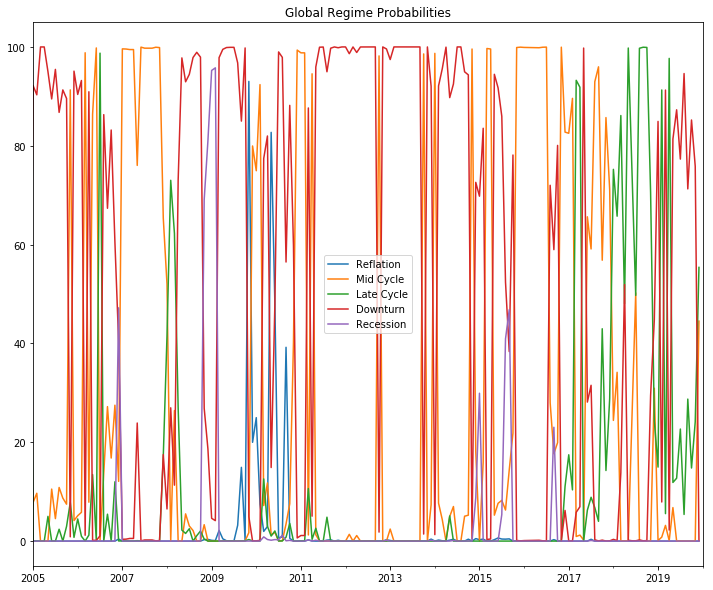

In [43]:
% matplotlib  inline


TotalProb.plot(figsize=(12,10))
plt.axis(['2005-01-01',EndDate,-5,105])
plt.title('Global Regime Probabilities')